In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sagemaker
import boto3
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',None) # To display all columns
pd.set_option('display.max_rows',None) # To display all columns
client = boto3.client('s3')
import feather
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from functools import reduce

In [2]:
KT1=pd.read_feather('s3://haseebdata/EDNET DATA/Ednet feather files/KT1.ftr')
questions_df = pd.read_csv('s3://haseebdata/EDNET DATA/EDNET Content CSV/questions.csv')

In [3]:
K1_userid_counts = KT1.user_iD.value_counts()
mask = K1_userid_counts >= 30
filtered_userids = mask[mask].index
K1 = KT1[KT1.user_iD.isin(filtered_userids)]

In [4]:
# subset df for notnull question_id rows only (only work with rows that have questions)
df2 = K1[K1['question_id'].notnull()]
df2.question_id = df2.question_id.str.slice(start=1)

In [5]:
df2.head()

,timestamp,solving_id,question_id,user_answer,elapsed_time,user_iD
0,1565096190868,1,5012,b,38000,1
1,1565096221062,2,4706,c,24000,1
2,1565096293432,3,4366,b,68000,1
3,1565096339668,4,4829,a,42000,1
4,1565096401774,5,6528,b,59000,1


In [6]:
questions_df.question_id = questions_df.question_id.str.slice(start=1)
questions_df.bundle_id = questions_df.bundle_id.str.slice(start=1)
questions_df.explanation_id = questions_df.explanation_id.str.slice(start=1)
questions_df.deployed_at = pd.to_datetime(questions_df.deployed_at, unit='ms')
dfq = questions_df[['question_id', 'correct_answer', 'bundle_id', 'part', 'tags', 'deployed_at']]
dfq.head()

,question_id,correct_answer,bundle_id,part,tags,deployed_at
0,1,b,1,1,1;2;179;181,2019-05-17 11:40:17.098
1,2,a,2,1,15;2;182,2019-05-17 11:40:19.720
2,3,b,3,1,14;2;179;183,2019-05-17 11:40:22.784
3,4,b,4,1,9;2;179;184,2019-05-17 11:40:25.357
4,5,c,5,1,8;2;179;181,2019-05-17 11:40:28.439


In [7]:
df2['user_iD'].nunique()

61103

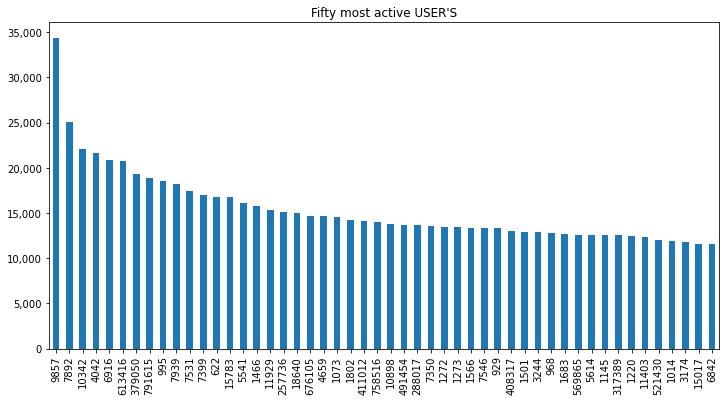

In [8]:
cids = df2.user_iD.value_counts()[:50]

fig = plt.figure(figsize=(12,6))
ax = cids.plot.bar()
plt.title("Fifty most active USER'S")
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

In [9]:
# left join student dataframe and answer key dataframe on the 'question_id' column 
dfm = pd.merge(df2, dfq,  how='left', left_on=['question_id'], right_on = ['question_id'])

In [10]:
# create a 'correct' column
dfm['correct'] = np.nan

# loop - if user answers == correct answer, then dfq['correct'][_]= 1
length_df = dfm['user_iD'].count()
count = 0
for i in range(length_df):
    if dfm['user_answer'][count] == dfm['correct_answer'][count]:
        dfm['correct'][count] = 1
    if dfm['user_answer'][count] != dfm['correct_answer'][count]:
        dfm['correct'][count] = 0
    count+=1

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
dfm.to_feather('EDNET.ftr')

In [12]:
df_total_questions_attempted = dfm.groupby(['user_iD'], as_index=False , sort=False)['question_id'].count()

df_total_questions_attempted = df_total_questions_attempted.rename(columns={'question_id': 'Total Questions Attempted'})                                                               

In [13]:
df_correct = dfm[dfm['correct']==1].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_correct = df_correct.rename(columns={'question_id': 'Corrected'})

In [14]:
df_incorrect = dfm[dfm['correct']==0].groupby(['user_iD'], as_index=False, sort=False)['question_id'].count()

df_incorrect = df_incorrect.rename(columns={'question_id': 'Incorrected'})

In [15]:
dfs = [df_total_questions_attempted, df_correct, df_incorrect]
df_final = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [16]:
df_final['Percentage'] = (df_final['Corrected'] / df_final['Total Questions Attempted']) *100
df_final.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage
0,1,1082,753,329,69.593346
1,100,33,18,15,54.545455
2,1000,1488,930,558,62.500000
3,10004,2486,1790,696,72.003218
4,100043,714,328,386,45.938375


In [17]:
df_final.to_csv('df_60K.csv')

In [18]:
df_60K = pd.read_csv('df_60K.csv')

In [19]:
KT1['elapsed_time']= KT1.elapsed_time.div(1000)   #DIVDING THE ELAPSED TIME by 1000 to further check the mean elapsed time by each user

In [20]:
Elapsed_time= KT1.groupby('user_iD' , sort=False)['elapsed_time'].median()

In [21]:
Elapsed_time.to_csv('Elapsedtime_60K.csv')

In [22]:
Times = pd.read_csv('Elapsedtime_60K.csv')

In [23]:
dfs = [df_60K, Times]
df = reduce(lambda left,right: pd.merge(left,right,on='user_iD'), dfs)

In [24]:
df.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,1,1082,753,329,69.593346,36.75
1,100,33,18,15,54.545455,34.50
2,1000,1488,930,558,62.500000,34.00
3,10004,2486,1790,696,72.003218,25.00
4,100043,714,328,386,45.938375,35.00


In [25]:
df.to_csv('data_60K.csv')

In [2]:
df=pd.read_csv('data_60K.csv')

In [4]:
del df['Unnamed: 0']
df.head()

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
0,1,1082,753,329,69.593346,36.75
1,100,33,18,15,54.545455,34.50
2,1000,1488,930,558,62.500000,34.00
3,10004,2486,1790,696,72.003218,25.00
4,100043,714,328,386,45.938375,35.00


In [11]:
df['Total Questions Attempted'].describe()

count    61100.000000
mean       480.745876
std       1004.493383
min         30.000000
25%         61.000000
50%        149.000000
75%        455.000000
max      34379.000000
Name: Total Questions Attempted, dtype: float64

In [14]:
df['Corrected'].describe()

count    61100.000000
mean       318.239918
std        701.559178
min          2.000000
25%         36.000000
50%         93.000000
75%        293.000000
max      24622.000000
Name: Corrected, dtype: float64

In [12]:
df['elapsed_time'].describe()

count    61100.000000
mean        23.245210
std          6.933314
min          0.000000
25%         19.000000
50%         22.000000
75%         26.000000
max        356.500000
Name: elapsed_time, dtype: float64

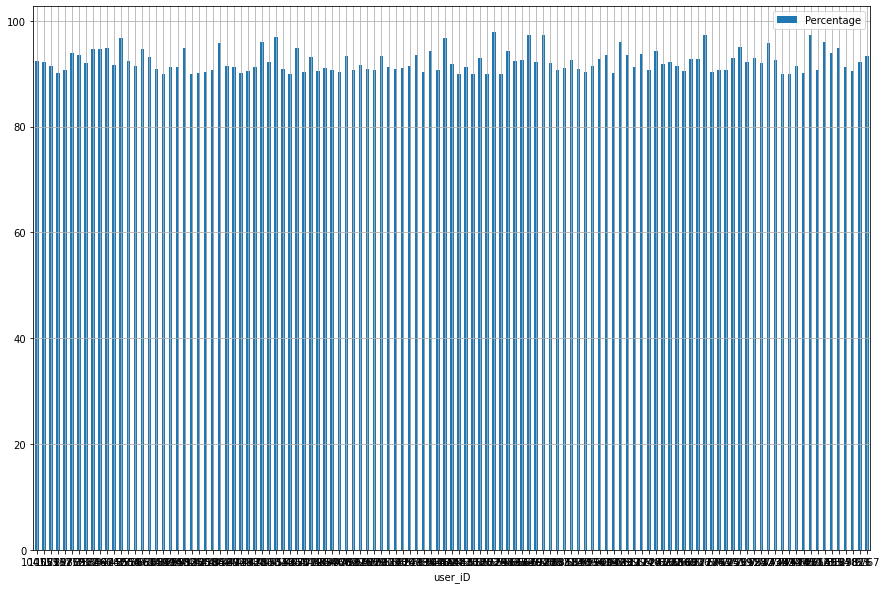

In [5]:
df_90 = df.loc[df['Percentage'] >= 90]
df_90.plot(x="user_iD" , y=['Percentage'] , kind = "bar" , figsize =(15,10) , rot=0).grid()

In [6]:
df_90['user_iD'].nunique()

119

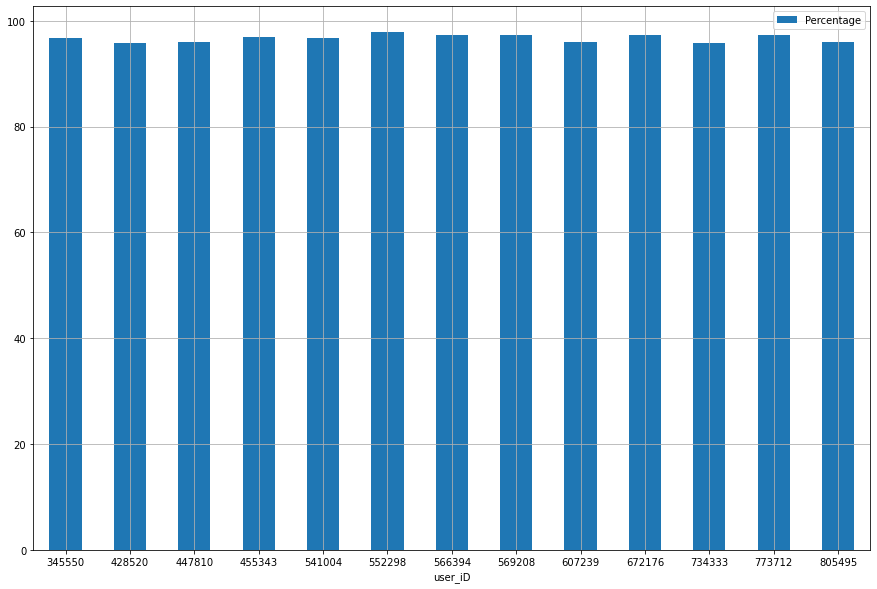

In [7]:
df_95 = df.loc[df['Percentage'] >= 95]
df_95.plot(x="user_iD" , y=['Percentage'] , kind = "bar" , figsize =(15,10) , rot=0).grid()

In [8]:
df_95['user_iD'].nunique()

13

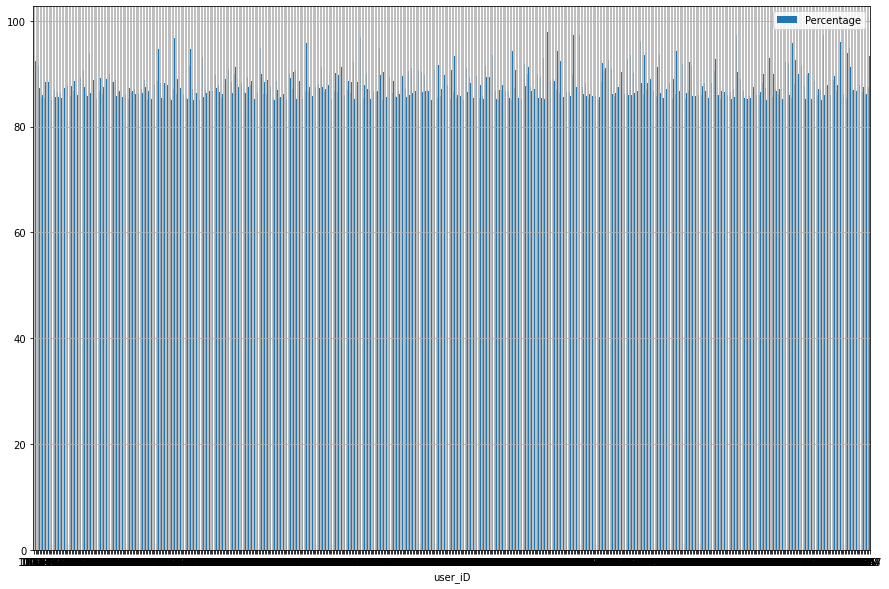

In [9]:
df_85 = df.loc[df['Percentage'] >= 85]
df_85.plot(x="user_iD" , y=['Percentage'] , kind = "bar" , figsize =(15,10) , rot=0).grid()

In [10]:
df_85['user_iD'].nunique()

577

In [16]:
df_USER = df.loc[df['Corrected'] == 24622]

In [17]:
df_USER

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
61027,9857,34379,24622,9757,71.619302,24.0


In [18]:
df_USER_low = df.loc[df['Corrected'] == 2]

In [19]:
df_USER_low

,user_iD,Total Questions Attempted,Corrected,Incorrected,Percentage,elapsed_time
12431,3280,31,2,29,6.451613,2.333
55499,765037,30,2,28,6.666667,16.000
57621,802971,35,2,33,5.714286,19.000
58785,814925,39,2,37,5.128205,19.000


In [6]:
df2['elapsed_time']= df2.elapsed_time.div(1000)
A= df2.groupby('user_iD')['elapsed_time'].mean()

In [7]:
A.head()

user_iD
1    49.578442
4    29.187740
5    27.130551
7    26.444315
9    40.830322
Name: elapsed_time, dtype: float64

In [9]:
A.plot